In [0]:
!pip install -U mxnet-cu101mkl==1.6.0  # updating mxnet to at least v1.6
!pip install gluoncv

     |████████████████████████████████| 711.0MB 26kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 757kB 2.7MB/s 


In [0]:
import os

import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
import gluoncv as gcv

In [0]:
from mxnet import gluon, autograd, lr_scheduler
from mxnet.gluon import nn

from mxnet.gluon.data.vision import transforms

from gluoncv import model_zoo, utils

In [0]:
num_gpus = 1

ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]

In [0]:
jitter_param = 0.4
lighting_param = 0.1

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(brightness=jitter_param, contrast=jitter_param,
                                 saturation=jitter_param),
    transforms.RandomLighting(lighting_param),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [0]:
dataset_path = '/content/drive/My Drive/Custom_Datasets/food_dataset'

classes = ['borscht', 'lagman', 'manty', 'plov', 'samsy']

In [0]:
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')

In [0]:
batch_size = 64

In [0]:
train_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, num_workers=-1)

In [0]:
test_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers=-1)

In [0]:
len(train_data), len(test_data)

(42, 8)

In [0]:
train_dataset = gluon.data.vision.ImageFolderDataset(train_path)

In [0]:
utils.viz.plot_image(train_dataset[1070][0])

In [0]:
# Model

model_name = 'ResNet50_v2'

In [0]:
finetune_net = model_zoo.get_model(model_name, pretrained=True)

In [0]:
with finetune_net.name_scope():
    finetune_net.output = nn.Dense(len(classes))

In [0]:
finetune_net

ResNetV2(
  (features): HybridSequential(
    (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=True, use_global_stats=False, in_channels=3)
    (1): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
    (3): Activation(relu)
    (4): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (5): HybridSequential(
      (0): BottleneckV2(
        (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
        (conv1): Conv2D(64 -> 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
        (conv2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn3): BatchNorm(axis=1, eps=1e-0

In [0]:
finetune_net.initialize(mx.init.Xavier(), ctx=ctx);

/usr/local/lib/python3.6/dist-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'resnetv27_batchnorm0_gamma' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.6/dist-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'resnetv27_batchnorm0_beta' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.6/dist-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'resnetv27_batchnorm0_running_mean' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.6/dist-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'resnetv27_batchnorm0_running_var' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init,

In [0]:
finetune_net.collect_params().reset_ctx(ctx)

In [0]:
finetune_net.hybridize()

In [0]:
wd = 0.001
lr = 0.001

# scheduler = lr_scheduler.MultiFactorScheduler(step=5, factor=0.5, base_lr=0.1)

In [0]:
trainer = gluon.Trainer(finetune_net.collect_params(), 'adam', {'learning_rate': lr, 'wd': wd})

In [0]:
metric = mx.metric.Accuracy()
criterion = gluon.loss.SoftmaxCrossEntropyLoss()

In [0]:
def test(net, val_data, ctx):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)

    return metric.get()

In [0]:
from tqdm.notebook import tqdm # iteration load bar
import time

In [0]:
lr_decay = 0.8
lr_steps = 10
epochs = 50

In [0]:
lr_counter = 0
num_batch = len(train_data)

train_acc_outputs = []
test_acc_outputs = []
cost_outputs = []

In [0]:
for epoch in range(epochs):
    if (epoch % lr_steps == 0 and epoch != 0):
        trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        print(f"Learning rate is decreased by {lr_decay}. Current lr: {trainer.learning_rate}")
        lr_counter += 1

    tic = time.time()
    cost = 0
  
    metric.reset()

    for i, batch in tqdm(enumerate(train_data)):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)

        with autograd.record():
            outputs = [finetune_net(X) for X in data]
            loss = [criterion(y_pred, y) for y_pred, y in zip(outputs, label)]
        
        for l in loss:
            l.backward()

        trainer.step(batch_size)

        cost += sum([l.mean().asscalar() for l in loss]) / len(loss)

        metric.update(label, outputs)
    
    _, train_acc = metric.get()
    train_acc_outputs.append(train_acc)

    cost /= num_batch
    cost_outputs.append(cost)

    _, val_acc = test(finetune_net, test_data, ctx)
    test_acc_outputs.append(val_acc)

    print("[Epoch %d] Train-acc: %.3f, train-loss: %.3f | Test-acc: %.3f | time: %.1f" %
            (epoch, train_acc, cost, val_acc, time.time() - tic))


[Epoch 0] Train-acc: 0.691, train-loss: 0.894 | Test-acc: 0.964 | time: 52.9



[Epoch 1] Train-acc: 0.797, train-loss: 0.599 | Test-acc: 0.881 | time: 52.6



[Epoch 2] Train-acc: 0.808, train-loss: 0.553 | Test-acc: 0.915 | time: 52.7



[Epoch 3] Train-acc: 0.825, train-loss: 0.487 | Test-acc: 0.915 | time: 52.5



[Epoch 4] Train-acc: 0.830, train-loss: 0.491 | Test-acc: 0.728 | time: 52.4



[Epoch 5] Train-acc: 0.821, train-loss: 0.503 | Test-acc: 0.972 | time: 53.1



[Epoch 6] Train-acc: 0.835, train-loss: 0.491 | Test-acc: 0.891 | time: 52.9



[Epoch 7] Train-acc: 0.836, train-loss: 0.476 | Test-acc: 0.732 | time: 52.8



[Epoch 8] Train-acc: 0.842, train-loss: 0.436 | Test-acc: 0.968 | time: 52.8



[Epoch 9] Train-acc: 0.846, train-loss: 0.454 | Test-acc: 0.981 | time: 52.3
Learning rate is decreased by 0.8. Current lr: 0.0008



[Epoch 10] Train-acc: 0.850, train-loss: 0.440 | Test-acc: 0.923 | time: 52.3



[Epoch 11] Train-acc: 0.850, train-loss: 0.439 | Test-acc: 0.904 | time: 52.9



[Epoch 12] Train-acc: 0.845, train-loss: 0.438 | Test-acc: 0.943 | time: 52.8



[Epoch 13] Train-acc: 0.864, train-loss: 0.410 | Test-acc: 0.951 | time: 53.0



[Epoch 14] Train-acc: 0.858, train-loss: 0.418 | Test-acc: 0.981 | time: 52.6



[Epoch 15] Train-acc: 0.861, train-loss: 0.402 | Test-acc: 0.896 | time: 52.8



[Epoch 16] Train-acc: 0.858, train-loss: 0.407 | Test-acc: 0.921 | time: 52.9



[Epoch 17] Train-acc: 0.851, train-loss: 0.442 | Test-acc: 0.836 | time: 52.5



[Epoch 18] Train-acc: 0.841, train-loss: 0.465 | Test-acc: 0.964 | time: 52.6



[Epoch 19] Train-acc: 0.863, train-loss: 0.420 | Test-acc: 0.906 | time: 52.5
Learning rate is decreased by 0.8. Current lr: 0.00064



[Epoch 20] Train-acc: 0.870, train-loss: 0.366 | Test-acc: 0.991 | time: 52.9



[Epoch 21] Train-acc: 0.882, train-loss: 0.354 | Test-acc: 0.977 | time: 53.0



[Epoch 22] Train-acc: 0.866, train-loss: 0.372 | Test-acc: 0.983 | time: 52.8



[Epoch 23] Train-acc: 0.875, train-loss: 0.374 | Test-acc: 0.938 | time: 53.2



[Epoch 24] Train-acc: 0.864, train-loss: 0.383 | Test-acc: 0.949 | time: 52.4



[Epoch 25] Train-acc: 0.882, train-loss: 0.354 | Test-acc: 0.989 | time: 52.6



[Epoch 26] Train-acc: 0.877, train-loss: 0.361 | Test-acc: 0.966 | time: 52.7



[Epoch 27] Train-acc: 0.876, train-loss: 0.362 | Test-acc: 0.962 | time: 52.4



[Epoch 28] Train-acc: 0.871, train-loss: 0.362 | Test-acc: 0.774 | time: 52.8



[Epoch 29] Train-acc: 0.877, train-loss: 0.379 | Test-acc: 0.787 | time: 52.9
Learning rate is decreased by 0.8. Current lr: 0.0005120000000000001



[Epoch 30] Train-acc: 0.882, train-loss: 0.349 | Test-acc: 0.996 | time: 53.2



[Epoch 31] Train-acc: 0.897, train-loss: 0.314 | Test-acc: 0.994 | time: 53.3



[Epoch 32] Train-acc: 0.905, train-loss: 0.284 | Test-acc: 0.994 | time: 53.5



[Epoch 33] Train-acc: 0.887, train-loss: 0.326 | Test-acc: 0.994 | time: 52.5



[Epoch 34] Train-acc: 0.896, train-loss: 0.316 | Test-acc: 0.989 | time: 52.6



[Epoch 35] Train-acc: 0.883, train-loss: 0.323 | Test-acc: 0.940 | time: 52.6



[Epoch 36] Train-acc: 0.890, train-loss: 0.319 | Test-acc: 0.991 | time: 52.7



[Epoch 37] Train-acc: 0.895, train-loss: 0.305 | Test-acc: 0.991 | time: 52.5



[Epoch 38] Train-acc: 0.888, train-loss: 0.312 | Test-acc: 0.991 | time: 52.6



[Epoch 39] Train-acc: 0.900, train-loss: 0.292 | Test-acc: 0.987 | time: 52.6
Learning rate is decreased by 0.8. Current lr: 0.0004096000000000001



[Epoch 40] Train-acc: 0.904, train-loss: 0.289 | Test-acc: 0.987 | time: 52.8



[Epoch 41] Train-acc: 0.906, train-loss: 0.269 | Test-acc: 0.981 | time: 52.6



[Epoch 42] Train-acc: 0.899, train-loss: 0.301 | Test-acc: 0.996 | time: 53.1



[Epoch 43] Train-acc: 0.909, train-loss: 0.278 | Test-acc: 0.991 | time: 52.7



[Epoch 44] Train-acc: 0.906, train-loss: 0.271 | Test-acc: 0.991 | time: 52.7



[Epoch 45] Train-acc: 0.916, train-loss: 0.254 | Test-acc: 0.972 | time: 52.7



[Epoch 46] Train-acc: 0.917, train-loss: 0.251 | Test-acc: 0.981 | time: 53.0



[Epoch 47] Train-acc: 0.918, train-loss: 0.247 | Test-acc: 0.985 | time: 53.1



[Epoch 48] Train-acc: 0.912, train-loss: 0.264 | Test-acc: 0.991 | time: 53.2



[Epoch 49] Train-acc: 0.909, train-loss: 0.268 | Test-acc: 0.996 | time: 53.0


In [0]:
save_filename = f"{model_name}_epochs{epochs}-lr{lr}-wd{wd}"
save_path = os.path.join('/content/drive/My Drive/Deep Learning/MXNet', save_filename)

finetune_net.export(save_path)

In [0]:
im_address = 'https://e0.edimdoma.ru/data/recipes/0010/8500/108500-ed4_wide.jpg?1511538678'
im_fname = utils.download(im_address, path='test.jpg', overwrite=True)

test_image = transform_test(mx.image.imread(im_fname))
test_image = test_image.expand_dims(axis=0).copyto(ctx[0])














  0%|          | 0/48 [00:00<?, ?KB/s]












100%|██████████| 48/48 [00:00<00:00, 162.34KB/s]


In [0]:
prediction = finetune_net(test_image)

classes[int(prediction.argmax().asscalar())]

'manty'

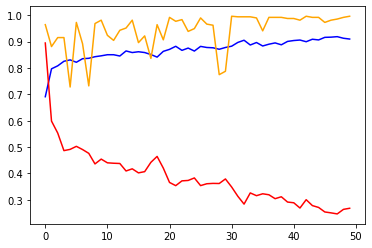

In [0]:
plt.plot(list(range(epochs)), train_acc_outputs, label='train_acc', color='blue')
plt.plot(list(range(epochs)), test_acc_outputs, label='test_acc', color='orange')
plt.plot(list(range(epochs)), cost_outputs, label='cost', color='red')